<a href="https://colab.research.google.com/github/stemgene/Python-Diary/blob/master/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/gdrive')

import pandas as pd
import numpy as np
import csv
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [11]:
attributes = ['PatientId', 'AppointmentID','Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
with open('/gdrive/My Drive/UR/DSC481/Project/noshowdata.csv') as csv_file:
  next(csv_file)
  csv_reader = csv.reader(csv_file, delimiter=',')
  df = pd.DataFrame(csv_reader, columns=attributes)




# Insert the 5th column that indicate the weekday of AppointmentDay
# dt.weekday: Monday-0, Friday-4, Sunday-6
df.insert(5, "Appoint Weekday", df.loc[:, 'AppointmentDay'].apply(np.datetime64).dt.weekday)

# Transform str to pd.datestamp and date form
df.loc[:, 'ScheduledDay'] = df.loc[:, 'ScheduledDay'].apply(np.datetime64).dt.date
df.loc[:, 'AppointmentDay'] = df.loc[:, 'AppointmentDay'].apply(np.datetime64).dt.date

# Insert the 6th column that indicate the difference between scheduled date and appointment date
date_difference = []
for i in range(len(df.loc[:, 'ScheduledDay'])):
  diff = (df.loc[:, 'AppointmentDay'][i]-df.loc[:, 'ScheduledDay'][i]).days
  date_difference.append(diff)
df.insert(6, "Date Difference", date_difference)

#cluster
drop=['ILHAS OCEÂNICAS DE TRINDADE', 'PARQUE INDUSTRIAL']
df = df[~df['Neighbourhood'].isin(drop)]
cl15 = pd.read_csv('/gdrive/My Drive/UR/DSC481/Project/cluster_kmeans15.csv')[['K-means cluster']]
cl15.rename(columns={'K-means cluster': 'Cluster'}, inplace=True)
df = df.reset_index(drop=True)
df =  pd.concat([df, cl15], axis=1)
print('cl15.shape: ',cl15.shape, "df.shape: ", df.shape)


df = df[df['Date Difference'] >= 0]
df.info(verbose=True)




# missing rumber&rate check
Miss_rate= pd.DataFrame(columns=["Missnum","Missrate"] )

for i in df.columns:
    
    mis=df[i].isnull().sum()
    r=(mis /len(df)) * 100
    Miss_rate.loc[i,'Missnum']=mis
    Miss_rate.loc[i,'Missrate']=r
    
Miss_thres= Miss_rate.sort_values(by = "Missrate", ascending=False).reset_index(drop=False)
Miss_thres




# one-hot coding
df['Male'] = np.where(df['Gender']== "M", 1, 0)
df['Label'] = np.where(df['No-show']=="Yes", 1, 0)
cat_columns = ['Handcap','Appoint Weekday', 'Cluster']
df = pd.get_dummies(df, prefix_sep="__",
                              columns=cat_columns)
print(df.head())



cl15.shape:  (110524, 1) df.shape:  (110524, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110519 entries, 0 to 110523
Data columns (total 17 columns):
PatientId          110519 non-null object
AppointmentID      110519 non-null object
Gender             110519 non-null object
ScheduledDay       110519 non-null object
AppointmentDay     110519 non-null object
Appoint Weekday    110519 non-null int64
Date Difference    110519 non-null int64
Age                110519 non-null object
Neighbourhood      110519 non-null object
Scholarship        110519 non-null object
Hipertension       110519 non-null object
Diabetes           110519 non-null object
Alcoholism         110519 non-null object
Handcap            110519 non-null object
SMS_received       110519 non-null object
No-show            110519 non-null object
Cluster            110519 non-null int64
dtypes: int64(3), object(14)
memory usage: 15.2+ MB
         PatientId AppointmentID Gender  ... Cluster__12 Cluster__13  Cluster

no     81654
yes    28865
Name: under18, dtype: int64


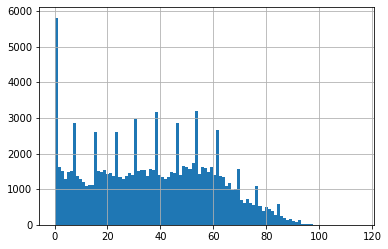

In [8]:
# age
# 28866(26%) patients are under 18, probably not appropriate to drop them
df['under18'] =  np.where(df['Age'].astype(int)>18, "no", "yes" )
print(df['under18'].value_counts())

# delete rows with age<0
df.drop(df[df['Age'].astype(int) < 0].index, inplace = True) 

hist = df['Age'].astype(int).hist(bins=100)
hist

# normalize (instead of grouping, i remember back in class jack said grouping age will cause information loss)
from sklearn import preprocessing
age = df[['Age']].values.astype(int)
min_max_scaler = preprocessing.MinMaxScaler()
df['age_scaled'] =  min_max_scaler.fit_transform(age)
 



Noshow History

(62295, 2) 
 count    62295.000000
mean         1.774107
std          1.770265
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: Visit_Nth_max, dtype: float64


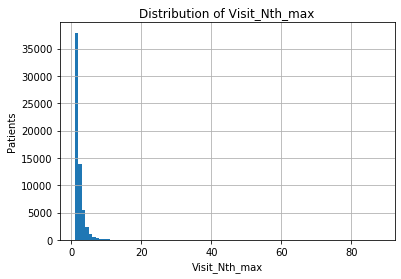

0.00     1.0
0.25     1.0
0.50     1.0
0.75     2.0
0.85     3.0
0.90     3.0
0.95     4.0
0.99     8.0
1.00    88.0
Name: Visit_Nth_max, dtype: float64


In [9]:
## check
df['Label'].value_counts()
## distinct PatientId count
len(df['PatientId'].unique())

df_visit=df.sort_values(by=['PatientId','ScheduledDay'])

##  visit
df_visit['Visit_Nth']=df_visit.groupby('PatientId').cumcount()+1

df_visit['New_Visit']=df_visit['Visit_Nth'].apply(lambda x: 1 if x==1 else 0)

df_visit['Noshow_cumsum']=df_visit.groupby('PatientId')['Label'].cumsum()

### noshow rate 
def noshow_rate(df):
    if df['Visit_Nth']==1:
        rate = 0
        
    elif df['Visit_Nth']>1:
        if df['Label']==1:
            rate = (df['Noshow_cumsum']-1 )/ (df['Visit_Nth'] -1 )
        else:
            rate = (df['Noshow_cumsum']  )/ (df['Visit_Nth'] -1 )       
    return rate

df_visit['Noshow_rate']= df_visit.apply(noshow_rate, axis=1)

## check
df_visit.head(20)

## max
df_max= pd.DataFrame(df_visit.groupby('PatientId')['Visit_Nth'].max()).reset_index()
df_max = df_max.rename(columns={'Visit_Nth':'Visit_Nth_max'} )
df_max.head()

## check unique patients
print(df_max.shape,"\n",df_max['Visit_Nth_max'].describe())
df_max['Visit_Nth_max'].value_counts()

## hist
df_max.hist(bins=88,label='Visit_Nth_max');
plt.xlabel("Visit_Nth_max")
plt.ylabel("Patients")
plt.title("Distribution of Visit_Nth_max")
plt.show()

## outlier defined
cut_list = [0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 1]
cut_Visit_Nth_max = df_max['Visit_Nth_max'].quantile(q=cut_list)
print(cut_Visit_Nth_max)
## decide to drop top 1%: keep Visit_Nth_max <=8

## merge
df_fin= df_visit.merge(df_max, on='PatientId', how='left')
df_fin.shape

## check
df_fin.tail(10)

## check
(df_fin[df_fin.Noshow_rate>0 & (df_fin.Noshow_rate<1)]).tail(10)

## check
df_fin[df_fin.PatientId=='99966898398164']

df= df_fin.copy()

## drop outlier
df= df[df['Visit_Nth_max']<=8]

## only keep Noshow_rate and New_Visit
df = df.drop(['Visit_Nth','Noshow_cumsum','Visit_Nth_max'], axis=1)


# Splittig data by PatientId,  Over-sampling using SMOTE




In [6]:
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import SMOTE
import seaborn as sns

# splitting by patientid
_, id_indices = np.unique(np.array(df['PatientId']), return_inverse=True)
train_ids, val_test_ids = next(GroupShuffleSplit(test_size=.30, n_splits=2, random_state = 8).split(df, groups=id_indices))

val_test_set = df.iloc[val_test_ids]
_, id_indices = np.unique(np.array(val_test_set['PatientId']), return_inverse=True)
val_ids, test_ids = next(GroupShuffleSplit(test_size=.50, n_splits=2, random_state = 8).split(val_test_set , groups=id_indices))

train_set = df.iloc[train_ids]
val_set =  df.iloc[val_ids]
test_set =  df.iloc[test_ids]


check =  any(item in train_set['PatientId'] for item in (val_set['PatientId']))
if check:
  print("train_set['PatientId'] contains some elements of val_set['PatientId']")      
else:
  print("train_set['PatientId'] does not have any element of val_set['PatientId'].")

check =  any(item in train_set['PatientId'] for item in (test_set['PatientId']))
if check:
  print("train_set['PatientId'] contains some elements of test_set['PatientId']")      
else:
  print("train_set['PatientId'] does not have any element of test_set['PatientId'].")


check =  any(item in val_set['PatientId'] for item in (test_set['PatientId']))
if check:
  print("val_set['PatientId'] contains some elements of test_set['PatientId']")      
else:
  print("val_set['PatientId'] does not have any element of test_set['PatientId'].")





drops = ['Label','No-show',"Gender",'AppointmentID', 'PatientId', 'ScheduledDay',	'AppointmentDay', 'No-show', 'Age','under18', 'Neighbourhood']
X_train = train_set.drop(drops, axis=1)
y_train = train_set['Label']

X_val = val_set.drop(drops, axis=1)
y_val = val_set['Label']

X_test = test_set.drop(drops, axis=1)
y_test = test_set['Label']


print("\nX_train.shape: ", X_train.shape)
print("X_val.shape: ", X_val.shape)
print("X_test.shape: ", X_test.shape)
print("df.shape: ", df.shape)



# Resample the minority class
sm = SMOTE(sampling_strategy='minority',random_state=8)
type(train_set)
X_train_os, y_train_os = sm.fit_sample(train_set.drop(drops, axis=1), train_set['Label'])
X_val_os, y_val_os = sm.fit_sample(val_set.drop(drops, axis=1), val_set['Label'])
X_test_os, y_test_os = sm.fit_sample(test_set.drop(drops, axis=1), test_set['Label'])

plt.figure(figsize=(12, 16))
plt.subplot(3, 2, 1)
sns.countplot(x = 'Label', data=pd.DataFrame(y_train, columns=['Label']))
plt.title('Unbalanced Classes - training set')


plt.subplot(3, 2, 2)
sns.countplot(x = 'Label', data=pd.DataFrame(y_train_os, columns=['Label']))
plt.title('Balanced Classes- training set')



plt.subplot(3, 2, 3)
sns.countplot(x = 'Label', data=pd.DataFrame(y_val, columns=['Label']))
plt.title('Unbalanced Classes - validation set')


plt.subplot(3, 2, 4)
sns.countplot(x = 'Label', data=pd.DataFrame(y_val_os, columns=['Label']))
plt.title('Balanced Classes - validation set')


plt.subplot(3, 2, 5)
sns.countplot(x = 'Label', data=pd.DataFrame(y_test, columns=['Label']))
plt.title('Unbalanced Classes - testing set')


plt.subplot(3, 2, 6)
sns.countplot(x = 'Label', data=pd.DataFrame(y_test_os, columns=['Label']))
plt.title('Balanced Classes - testing set')



plt.show()




train_set['PatientId'] does not have any element of val_set['PatientId'].
train_set['PatientId'] does not have any element of test_set['PatientId'].
val_set['PatientId'] does not have any element of test_set['PatientId'].

X_train.shape:  (73119, 37)
X_val.shape:  (15580, 37)
X_test.shape:  (15641, 37)
df.shape:  (104340, 46)


ValueError: ignored

## unbalanced sets:
X_train, y_train 

X_val, y_val

X_test, y_test

## balanced sets:
X_train_os, y_train_os

X_val_os, y_val_os

X_test_os, y_test_os

### Idea of dealing with data

*   calculate the difference of appontment day - scheduled day
*   label whic weakday of appointment day



In [0]:
# Logistic Regression
logreg = LogisticRegression(C=1e5, solver='liblinear', multi_class='ovr')
logreg_model = logreg.fit(X_train, y_train)
y_lr_pred = logreg_model.predict(X_test)


# SVM
# Ploynomial kernel
svclassifier_ploy = SVC(kernel='poly',degree=8)
svclassifier_ploy.fit(X_train, y_train)
# Gaussian Kernel
svclassifier_rbf = SVC(kernel='rbf')
svclassifier_rbf.fit(X_train, y_train)
# Sigmoid Kernel
svclassifier_sig = SVC(kernel='sigmoid')
svclassifier_sig.fit(X_train, y_train)
# Doin predictions
y_ploy_pred = svclassifier_ploy.predict(X_test)
y_rbf_pred = svclassifier_rbf.predict(X_test)
y_sig_pred = svclassifier_sig.predict(X_test)

# Decision Tree
dtc = DecisionTreeClassifier() 
dtc.fit(X_train, y_train)
y_dt_pred = dtc.predict(X_test)

# Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc_pred = rfc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
# Logistic Regression
print("The Logistic Regression accuracy classification score is", round(logreg_model.score(X_test, y_test),3))
print(confusion_matrix(y_test, y_lr_pred))
print(classification_report(y_test, y_lr_pred))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr_pred)

# SVM
s_ploy = round(svclassifier_ploy.score(X_test, y_test), 3)
s_rbf = round(svclassifier_rbf.score(X_test, y_test), 3)
s_sig = round(svclassifier_sig.score(X_test, y_test), 3)
c_ploy = confusion_matrix(y_test, y_ploy_pred)
c_rbf = confusion_matrix(y_test, y_rbf_pred)
c_sig = confusion_matrix(y_test, y_sig_pred)
cr_ploy = classification_report(y_test, y_ploy_pred)
cr_rbf = classification_report(y_test, y_rbf_pred)
cr_sig = classification_report(y_test, y_sig_pred)
print("The SVM accuracy score of different kernals are :\nPloynomial kernel {0}\n \
Gaussian Kernel: {1}\nSigmoid Kernel: {2}".format(s_ploy, s_rbf, s_sig))
print("The SVM confusion_matrix are:\nPloynomial kernel\n{0}\n \
Gaussian Kernel:\n{1}\n Sigmoid Kernel:\n{2}".format(c_ploy, c_rbf, c_sig))
print("The SVM classification reports are:\nPloynomial kernel\n{0}\n \
Gaussian Kernel:\n{1}\n Sigmoid Kernel:\n{2}".format(cr_ploy, cr_rbf, cr_sig))
fpr_svm_ploy, tpr_svm_ploy, _ = roc_curve(y_test, y_ploy_pred)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, y_rbf_pred)
fpr_svm_sig, tpr_svm_sig, _ = roc_curve(y_test, y_sig_pred)

#Decision Tree
print("The Decision Tree accuracy classification score is", round(dtc.score(X_test, y_test),3))
print(confusion_matrix(y_test, y_dt_pred))
print(classification_report(y_test, y_dt_pred, target_names=["0", "1"]))
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_dt_pred)

# Random Forest
print("The Random Forest accuracy classification score is", round(rfc.score(X_test, y_test),3))
print(confusion_matrix(y_test, y_rfc_pred))
print(classification_report(y_test, y_rfc_pred, target_names=["0", "1"]))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rfc_pred)

In [0]:
# linear kernal
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred=svclassifier.predict(X_test)
print('linear kernel \n', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



linear kernel 
 [[13242     0]
 [ 3335     1]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     13242
           1       1.00      0.00      0.00      3336

    accuracy                           0.80     16578
   macro avg       0.90      0.50      0.44     16578
weighted avg       0.84      0.80      0.71     16578



### For location category

In [0]:
import statistics as stat

mean = stat.mean(towns.values())
median = stat.median(towns.values())
print(f"The mean is {mean}, the median is {median}")

The mean is 1364, the median is 851


In [0]:
# Get the latlng of whose patient less than 10
under10 = {k:v for k,v in towns.items() if v <= 10}
for keys, values in under10.items():
  gis.get_json(keys + City)
  print( "The town is " + keys + str(gis.parse_json()) + ". The number of patients is" + str(values))

The town is AEROPORTO(-20.2616507, -40.2833315). The number of patients is8
The town is ILHA DO FRADE(-20.3020067, -40.2814162). The number of patients is10
The town is ILHAS OCEÂNICAS DE TRINDADE(-20.5080654, -29.3308425). The number of patients is2
The town is PARQUE INDUSTRIAL(-19.1834229, -40.3088626). The number of patients is1


In [0]:
# Get the latlng of whose patient more than 4000
top3 = {k:v for k,v in towns.items() if v > 4000}
for keys, values in top3.items():
  gis.get_json(keys + City)
  print( "The town is " + keys + str(gis.parse_json()) + ". The number of patients is" + str(values))

The town is JARDIM CAMBURI(-20.2592187, -40.26545309999999). The number of patients is7717
The town is MARIA ORTIZ(-19.1834229, -40.3088626). The number of patients is5805
The town is RESISTÊNCIA(-20.2729812, -40.3177959). The number of patients is4431


### 11.28 after cluster 用这个cluster_kmeans_df，别忘了integer cluster 

In [0]:

with open('/gdrive/My Drive/UR/DSC481/Project/cluster_kmeans15.csv') as csv_file:
  attributes = ['index','PatientId', 'town name', 'town gps', 'patient gps', 'clusters' ]
  next(csv_file)
  cluster_kmeans = csv.reader(csv_file, delimiter=',')
  cluster_kmeans_df = pd.DataFrame(cluster_kmeans, columns=attributes)
cluster_kmeans_df.tail()

,index,PatientId,town name,town gps,patient gps,clusters
110519,110522,2572134369293,MARIA ORTIZ,"(-20.258305, -40.2999279)",[[-20.25829084 -40.29996018]],4
110520,110523,3596266328735,MARIA ORTIZ,"(-20.258305, -40.2999279)",[[-20.25841998 -40.29996579]],4
110521,110524,15576631729893,MARIA ORTIZ,"(-20.258305, -40.2999279)",[[-20.25819621 -40.30020557]],4
110522,110525,92134931435557,MARIA ORTIZ,"(-20.258305, -40.2999279)",[[-20.25834054 -40.30018776]],4
110523,110526,377511518121127,MARIA ORTIZ,"(-20.258305, -40.2999279)",[[-20.2583346 -40.29988491]],4


In [0]:
# Drop "ILHAS OCEANICAS DE TRINDADE" and "PARQUE INDUSTRIAL"
df = df[df.Neighbourhood != "ILHAS OCEÂNICAS DE TRINDADE"]
df = df[df.Neighbourhood != "PARQUE INDUSTRIAL"]

In [0]:
# Get the latlng of whose patient less than 110
patient_loc = df[['Neighbourhood','PatientId']].groupby(["Neighbourhood"])
towns_keys = [el for el in patient_loc.groups.keys()] # approach of get keys after 'groupby'
patient_count = [patient_loc.count().iloc[i,0] for i in range(len(patient_loc.count()))]
towns = dict(zip(towns_keys, patient_count))
under110 = {k:v for k,v in towns.items() if v <= 110}
for keys, values in under110.items():
  gis.get_json(keys + City)
  print( "The town is " + keys + str(gis.parse_json()) + ". The number of patients is" + str(values))

The town is ILHA DO BOI(-20.2976178, -40.2957768). The number of patients is35
The town is MORADA DE CAMBURI(-20.2720492, -40.2967367). The number of patients is96
The town is PONTAL DE CAMBURI(-20.2900766, -40.2980132). The number of patients is69
